In [1]:
import torchvision
#from torchsummary import summary
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image
import json
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np

# Data

In [2]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

# validloader = torch.utils.data.DataLoader(validset.dataset, batch_size=128,
#                                           shuffle=False, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


# Model

In [3]:
class Resnet_block(nn.Module):
  def __init__(self,in_channels,out_channels,stride=1):
    super(Resnet_block,self).__init__()
    self.conv1=nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3,stride=stride,padding=1,bias=False)
    self.bn1= nn.BatchNorm2d(out_channels)
    self.relu1=nn.ReLU()

    self.conv2=nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False)
    self.bn2=nn.BatchNorm2d(out_channels)
    self.relu2=nn.ReLU()

    self.residual=nn.Sequential()
    if stride!=1 or in_channels!=out_channels:
      self.residual=nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size=1, stride=stride, bias=False),
                                  nn.BatchNorm2d(out_channels)
                                  )

  def forward(self,x):

    out=self.conv1(x)
    out=self.bn1(out)
    out= self.relu1(out)

    out =self.conv2(out)
    out =self.bn2(out)

    out +=self.residual(x)
    out= self.relu2(out)
    return out

In [4]:
class custom_Resnet(nn.Module):
  def __init__(self,block,n_start_filters,layers,num_classes,dropout_prob=0.5):
    super(custom_Resnet,self).__init__()
    self.in_channels=n_start_filters
    self.layer1=nn.Sequential(
    nn.Conv2d(3,n_start_filters,kernel_size=3,bias=False,padding=1),
    nn.BatchNorm2d(n_start_filters),
    nn.ReLU(inplace=True),
#     nn.Dropout2d(p=0.3)
    )
    self.layer2=self.make_layer(block,n_start_filters,layers[0],stride=1)
    self.layer3=self.make_layer(block,n_start_filters*2,layers[1],stride=2)
    self.layer4=self.make_layer(block,n_start_filters*4,layers[2],stride=2)
    # self.layer4=self.make_layer(block,n_start_filters*8,layers[3],stride=2)
    self.dropout = nn.Dropout(dropout_prob)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(self.in_channels, num_classes)


  def make_layer(self,block,out_channels,n_blocks,stride):
    layers=[]
    layers.append(block(self.in_channels,out_channels,stride))
    self.in_channels=out_channels
    layers.extend([block(out_channels,out_channels) for i in range(1,n_blocks)])
    return nn.Sequential(*layers)
    # layers = [layer1, layer2, layer3]
    # model = nn.Sequential(*layers)

  def forward(self, x):
        # out = self.conv1(x)
        # out = self.bn1(out)
        # out = self.relu(out)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Training

In [5]:
def initialize_parameters(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight.data, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight.data, gain=nn.init.calculate_gain('relu'))
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

In [6]:
def calculate_accuracy(y_pred, y):
    _, predicted = torch.max(y_pred.data, 1)
    correct = (predicted == y).sum().item()
    total = y.size(0)
    acc = 100 * correct / total
    return acc

In [9]:
# def train(model, data_loader, optimizer, criterion, device):

#     epoch_loss = 0
#     epoch_acc = 0

#     model.train()

#     for batch_idx, (inputs, targets) in enumerate(data_loader):

#         inputs = inputs.to(device)
#         targets = targets.to(device)

#         optimizer.zero_grad()

#         y_pred= model(inputs)

#         loss = criterion(y_pred, targets)



#         loss.backward()

#         optimizer.step()
#         lr_scheduler.step()
#         acc = calculate_accuracy(y_pred, targets)

#         epoch_loss += loss.item()
#         epoch_acc += acc

#     return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [10]:
# def evaluate(model, data_loader, criterion, device):

#     epoch_loss = 0
#     epoch_acc = 0

#     model.eval()

#     with torch.no_grad():

#         for batch_idx, (inputs, targets) in enumerate(data_loader):

#             inputs = inputs.to(device)
#             targets = targets.to(device)

#             y_pred = model(inputs)

#             loss = criterion(y_pred, targets)

#             acc = calculate_accuracy(y_pred, targets)

#             epoch_loss += loss.item()
#             epoch_acc += acc

#     return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [11]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [12]:
# model=custom_Resnet(Resnet_block,32,[13,13,13],10,0.5)

# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9,weight_decay=1e-4)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# criterion = nn.CrossEntropyLoss()
# max_lr = 0.1  # maximum learning rate
# div_factor = 10  # factor to divide the maximum learning rate by
# pct_start = 0.3  # percentage of the cycle used for increasing the learning rate

# lr_scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=div_factor,
#                        pct_start=pct_start, cycle_momentum=False,steps_per_epoch=400 ,epochs=210)
# model = model.to(device)
# criterion = criterion.to(device)

In [13]:
# train_metrics=[]
# test_metrics=[]
# import time
# val_acc_total=0
# EPOCHS=200

# for epoch in range (EPOCHS):
#   start_time=time.time()
#   train_loss,train_acc=train(model,trainloader,optimizer,criterion,device)
#   train_metrics.append([train_loss,train_acc])
#   print('Epoch [%d/%d], Training Accuracy: %.2f %%' % (epoch+1, EPOCHS, train_acc))
#   print('Epoch [%d/%d], Training Loss: %.4f' % (epoch+1, EPOCHS,train_loss))
#   val_loss,val_acc=evaluate(model,testloader,criterion,device)
#   test_metrics.append([val_loss,val_acc])
#   print('Epoch [%d/%d], Test Accuracy: %.2f %%, Test Loss:  %.2f' % (epoch+1, EPOCHS, val_acc, val_loss))
#   if val_acc_total<val_acc:
#     val_acc_total=val_acc
#     torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict()},'mini_proj/reg_13_itr7.ckpt') #saving the checkpoint if model's accuracy is better than earlier val accuracy
#     print('saving model!')
#   end_time=time.time()
#   # test_loss,test_acc=evaluate(model,testloader,criterion,device)
#   # print(test_loss,test_acc)
# #   lr_scheduler.step()
#   elapsed_mins, elapsed_secs=epoch_time(start_time,end_time)
#   print(f'Time Elapsed {elapsed_mins}m {elapsed_secs}s ')

In [14]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision.transforms import autoaugment

# Advanced Data Augmentation Techniques
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    autoaugment.AutoAugment(autoaugment.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))


# Moving model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
def train(model, data_loader, optimizer, criterion, device, lr_scheduler=None):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for batch_idx, (inputs, targets) in enumerate(data_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        loss.backward()
        
        optimizer.step()
        
        # Scheduler step call (if using OneCycleLR, it's per batch)
        if lr_scheduler is not None:
            lr_scheduler.step()
        
        _, preds = torch.max(outputs, 1)
        epoch_acc += torch.sum(preds == targets).item()
        epoch_loss += loss.item()

    return epoch_loss / len(data_loader), (epoch_acc / len(data_loader)) / data_loader.batch_size

In [16]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            _, preds = torch.max(outputs, 1)
            epoch_acc += torch.sum(preds == targets).item()
            epoch_loss += loss.item()

    return epoch_loss / len(data_loader), (epoch_acc / len(data_loader)) / data_loader.batch_size


In [17]:
import time

# Model, optimizer, and criterion setup
EPOCHS=200
model = custom_Resnet(Resnet_block, 32, [13, 13, 13], 10, 0.5).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)
# criterion = LabelSmoothingLoss(classes=10, smoothing=0.1).to(device)

criterion = nn.CrossEntropyLoss()
steps_per_epoch = len(trainloader)
total_steps = steps_per_epoch * EPOCHS  # EPOCHS is the total number of epochs you plan to train
lr_scheduler = OneCycleLR(optimizer, max_lr=0.003, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, div_factor=10, pct_start=0.3)


# Arrays to track training and validation loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


for epoch in range(EPOCHS):
    start_time = time.time()
    
    # Training
    train_loss, train_acc = train(model, trainloader, optimizer, criterion, device, lr_scheduler)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Evaluation
    val_loss, val_acc = evaluate(model, testloader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    end_time = time.time()
    
    print(f'Epoch: {epoch+1:02}/{EPOCHS} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.2f}% | Time: {end_time - start_time:.2f}s')
    
    # Optionally save model if it's the best so far
    if val_acc == max(val_accuracies):
        torch.save(model.state_dict(), 'best_model3.pth')
        print("Model saved at epoch:", epoch+1)

Epoch: 01/200 | Train Loss: 2.125 | Train Acc: 0.22% | Val Loss: 1.695 | Val Acc: 0.36% | Time: 39.76s
Model saved at epoch: 1
Epoch: 02/200 | Train Loss: 1.710 | Train Acc: 0.37% | Val Loss: 1.807 | Val Acc: 0.39% | Time: 33.76s
Model saved at epoch: 2
Epoch: 03/200 | Train Loss: 1.437 | Train Acc: 0.49% | Val Loss: 1.095 | Val Acc: 0.59% | Time: 33.73s
Model saved at epoch: 3
Epoch: 04/200 | Train Loss: 1.234 | Train Acc: 0.57% | Val Loss: 0.922 | Val Acc: 0.67% | Time: 34.09s
Model saved at epoch: 4
Epoch: 05/200 | Train Loss: 1.076 | Train Acc: 0.63% | Val Loss: 0.887 | Val Acc: 0.69% | Time: 33.87s
Model saved at epoch: 5
Epoch: 06/200 | Train Loss: 0.979 | Train Acc: 0.66% | Val Loss: 0.781 | Val Acc: 0.72% | Time: 33.86s
Model saved at epoch: 6
Epoch: 07/200 | Train Loss: 0.908 | Train Acc: 0.69% | Val Loss: 0.714 | Val Acc: 0.74% | Time: 33.68s
Model saved at epoch: 7
Epoch: 08/200 | Train Loss: 0.838 | Train Acc: 0.72% | Val Loss: 0.666 | Val Acc: 0.77% | Time: 33.97s
Model sa

KeyboardInterrupt: 

In [20]:
model = custom_Resnet(Resnet_block, 32, [13, 13, 13], 10, 0.5).to(device)
model.load_state_dict(torch.load('best_model3.pth'))
model = model.to(device)

In [21]:
val_loss, val_acc = evaluate(model, testloader, criterion, device)

In [22]:
val_acc, val_loss

(0.944620253164557, 0.2353580941835159)

In [26]:
import json

with open('train_accuracy_cross_entropy.json', 'w') as f:
    json.dump(train_accuracies, f)
with open('test_cross_entropy.json', 'w') as f:
    json.dump(val_accuracies, f)

with open('train_loss_cross_entropy.json', 'w') as f:
    json.dump(train_losses, f)
with open('test_loss_cross_entropy.json', 'w') as f:
    json.dump(val_losses, f)

In [ ]:
import json

train_metarics = []
test_metrics = []
# open a file in read mode and load the JSON data into the appropriate lists
with open('train_128_layer.json', 'r') as f:
    train_metrics = json.load(f)
with open('/content/drive/MyDrive/DL HW/min_proj_2/loss_tracks/test_128_layer.json', 'r') as f:
    test_metrics = json.load(f)


def plot_metrics(train_metrics,test_metrics):
    fig, axs = plt.subplots(2, 2, figsize=(15,10))
    axs[0, 0].plot([i[0] for i in train_metrics])
    axs[0, 0].set_title('Training Loss')
    axs[0, 1].plot([100-i[1] for i in train_metrics])
    axs[0, 1].set_title('Training error %')
    axs[1, 0].plot([i[0] for i in test_metrics])
    axs[1, 0].set_title('Test Loss')
    axs[1, 1].plot([100-i[1] for i in test_metrics])
    axs[1, 1].set_title('Test error %')

plot_metrics(train_metrics[9:],test_metrics[9:])

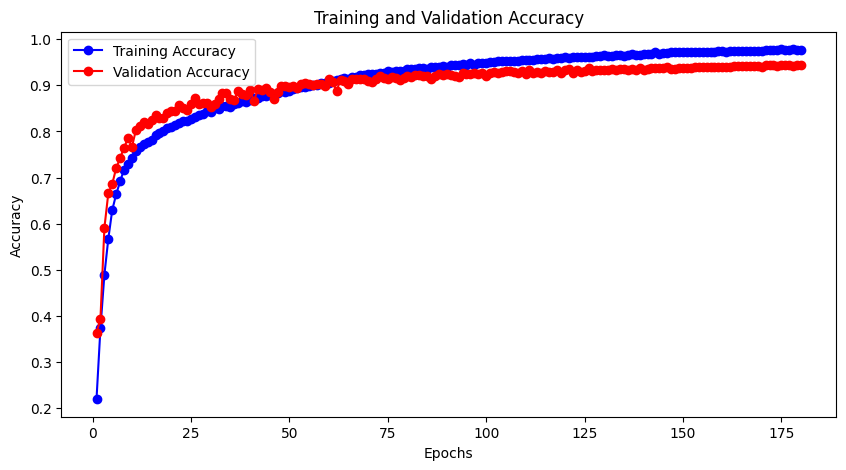

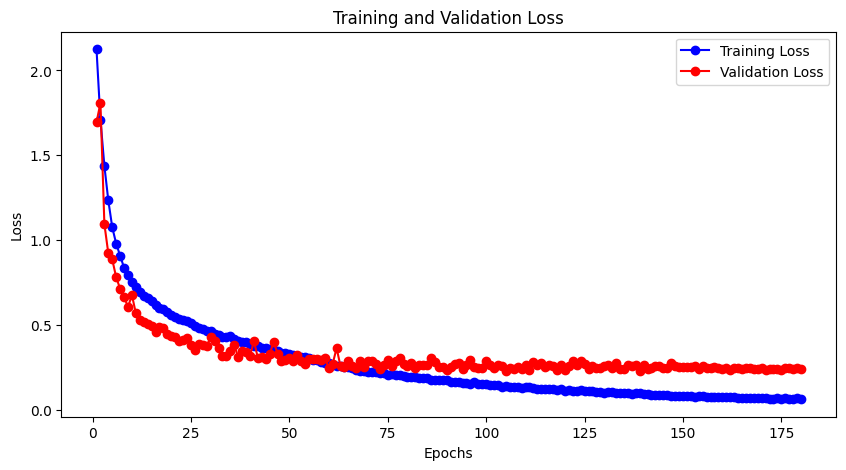

In [27]:
import matplotlib.pyplot as plt

# Assuming you have these lists filled with data from training
# train_accuracies, train_losses, val_accuracies, val_losses

# Number of epochs could be derived from the length of any of these lists
epochs = range(1, len(train_accuracies) + 1)

# Plotting training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Custom Dataset

In [28]:
import pickle
from torch.utils.data import DataLoader, Dataset

In [29]:
with open('cifar_test_nolabels.pkl', 'rb') as file:
    test_data_dict = pickle.load(file)

# Assuming that the data is a NumPy array, we need to create a custom Dataset for it.
class CIFARTestDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.data = data_dict[b'data']
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Assuming that the data is a flat array per image and needs reshaping.
        # CIFAR-10 images are 32x32 with 3 channels.
        # Adjust the reshape method if the images are stored in a different format.
        image = self.data[idx].reshape(3, 32, 32).transpose(1, 2, 0)
        if self.transform:
            image = self.transform(image)
        return image

# Creating an instance of the Dataset for test data.
test_dataset = CIFARTestDataset(data_dict=test_data_dict, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Rest of the code remains the same...

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Function to make predictions
def predict(model, test_loader):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())

    return predictions

# Load your trained model (make sure that the model is already loaded into the `model` variable and moved to the correct device)
# model = ... (Load your model here, ensure it is on eval mode and moved to the device)

# Get predictions
predictions = predict(model, test_loader)

# predictions will be a list or array with the predicted class indices

/ext3/miniconda3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
np.unique(predictions, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 862, 1006,  963, 1089,  984, 1092,  922,  996, 1040, 1046]))

In [30]:
np.unique(predictions, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 863, 1034,  954, 1111,  976, 1048,  932,  996, 1076, 1010]))

In [31]:
ids = []
for i in range(10000):
  ids.append(i)

import pandas as pd

df = pd.DataFrame(
    {'ID': ids,
     'Labels': predictions
    })


df.to_csv('preds.csv', index=False)